# 11/23/2024
Using scale, with only 2 degree deviation at j0 and j4 and no deviation at j1, j2, j3, j5, and make sure to take image from all angeles, works really good for now, will test other things as well.
7 images I took
- I tested with another data presented flat, and works really good
- now i test with a tilted data and it works really good, even if the joint travel are a lot and pose changes
- next i will test and see if the parameters are good for suronding points
- it is precise over different locations
- 
- now include rotation matrix in finding the optimized point, i want to see if dewer image will give me the same precision
- check if adding totation matrix in the T_cam_2_j4 will give me better result
- likelihood_3 is the best it does not consider rotation, only transation data and also the full eulelr 
- scale is not good for likelihood_3
- likelihood_3 with no scale, and take many images, it works really well
- 



In [6]:
#%matplotlib widget
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy.optimize import differential_evolution, minimize

from IPython.display import display, clear_output

from dorna_vision import Detection
from camera import Camera
from dorna2 import Dorna
import itertools
import time
D =[]
"""
helper functions
"""
# euler to transformation matrix
def euler_matrix(xyzabc):
    if len(xyzabc) == 6:
        cv0 = np.pi/2 - xyzabc[3]
        sv0 = 1- cv0**2 / 2
        sv1 = xyzabc[4] 
        cv1 = 1 - sv1**2 / 2
        sv2 = xyzabc[5] 
        cv2 = 1 - sv2**2 / 2

        retval = np.matrix([
                [cv1* cv0   , sv2*sv1*cv0 - cv2*sv0 , cv2*sv1*cv0 - sv2*sv0 , xyzabc[0]],
                [cv1 * sv0  , sv2*sv1*sv0 + cv2*cv0 , cv2*sv1*sv0 + sv2*cv0 , xyzabc[1]],
                [-sv1       , sv2*cv1               , cv2*cv1               , xyzabc[2]],
                [0,0,0,1]])
    else:
        retval = np.matrix([
                [0 , -1 , 0, xyzabc[0]],
                [1, 0, 0, xyzabc[1]],
                [0, 0, 1, xyzabc[2]],
                [0,0,0,1]])         
    return retval    


def Euler_matrix(abg,xyz):
    cv0 = np.cos(abg[0])
    sv0 = np.sin(abg[0]) 
    cv1 = np.cos(abg[1]) 
    sv1 = np.sin(abg[1]) 
    cv2 = np.cos(abg[2])
    sv2 = np.sin(abg[2])
    return np.matrix([
        [cv1* cv0   , sv2*sv1*cv0 - cv2*sv0 , cv2*sv1*cv0 - sv2*sv0 , xyz[0]  ],
        [cv1 * sv0  , sv2*sv1*sv0 + cv2*cv0 , cv2*sv1*sv0 + sv2*cv0 , xyz[1]  ],
        [-sv1       , sv2*cv1               , cv2*cv1               , xyz[2]  ],
        [0,0,0,1]])

"""
j0_true = j0 + p[6]
j1_true = j1 + p[7]
j2_true = j2 + p[8]
j3_true = j3 + p[9]
j4_true = j4 + p[10]
"""
def likelihood(p, data):
    # init
    total_error = 0
    num_data = 0

    for set in data:
        v =[]
        for d in set:
            if len(p) > 3:
                g = p[3]*d["A"] + (1-p[3])*np.array([d["kinematic"][0,3], d["kinematic"][1,3], d["kinematic"][2,3]]) + np.matmul( np.array(p[0:3]), d["B"]) 
            else:
                g = d["A"] + np.matmul( np.array(p[0:3]), d["B"]) 
            v.append(g)
            num_data = num_data + 1
    
        # compute centroid
        centroid = np.mean(v, axis=0)
        #centroid = np.array([262.449615, -269.020641, 64.018827])
        
        # compute distance
        d = [np.linalg.norm(g - centroid) for g in v]
        #total_error += np.std(d)
        total_error += np.mean(np.square(d))
    
    return total_error


def likelihood_2(p, data, robot): # rotation is also recorded
    # init
    total_error = 0
    num_data = 0

    for set in data:
        v =[]
        for d in set:
            g_matrix = (d["kinematic"] @ np.matrix([[0, -p[3], 0, p[0]], [p[3], 0, 0, p[1]], [0, 0, p[3], p[2]], [0, 0, 0, 1]])) @ d["target_2_cam"]

            g = robot.kinematic.mat_to_xyzabc(g_matrix)
            v.append(g)
            num_data = num_data + 1
    
        # compute centroid
        centroid = np.mean(v, axis=0)
        
        # compute distance
        d = [np.linalg.norm(g - centroid) for g in v]
        total_error += np.mean(np.square(d))
    
    print("centroid: ", centroid)
    return total_error

# p: x, y, z, ej0, ej1, ej2, ej3, ej4, ej5, 
# T: [[0 ,-1, 0, x],[1, 0, 0, y],[0, 0, 1, z],[0,0,0,1]]
def calibration_fast(p, data):
    global D
    # init
    total_error = 0
    num_data = 0
    for set in data:
        v =[]
        for d in set:
            g = ((d["H"][0]+p[3]*d["H"][1]+p[4]*d["H"][2]+p[5]*d["H"][3]+p[6]*d["H"][4]+p[7]*d["H"][5]) @ np.matrix([[p[1]], [-p[0]], [p[2]], [1]])).T
            v.append(g)
            num_data = num_data + 1
    
        # compute centroid
        centroid = np.mean(v, axis=0)
        
        # compute distance
        d = [np.linalg.norm(g - centroid) for g in v]
        D = list(d)
        total_error += np.mean(np.square(d))
    
    return total_error

# optimizing xyzabc
def rvec_calibration(p, data, xyz, ej=[0,0,0,0,0]): # no rotation only all the parameters for the euler matrix
    # init
    total_error = 0
    num_data = 0

    for set in data:
        v =[]
        for d in set:
            g = ((d["_kin"] @ Euler_matrix(p, xyz)) @ np.matrix([[d["gt"][0]], [d["gt"][1]], [d["gt"][2]], [1]])).T

            v.append(g)
            num_data = num_data + 1

        # compute centroid
        centroid = np.mean(v, axis=0)
        
        # compute distance
        d = [np.linalg.norm(g - centroid) for g in v]
        total_error += np.mean(np.square(d))
    
    return total_error


# optimizing xyzabc
def transformation_calibration(p, data, ej=[0,0,0,0,0]): # no rotation only all the parameters for the euler matrix
    # init
    total_error = 0
    num_data = 0

    for set in data:
        v =[]
        for d in set:
            if ej is [0,0,0,0,0]:
                kin = d["kinematic"]
            else:
                kin = d["jac"][0] + ej[0]*d["jac"][1] + ej[1]*d["jac"][2] + ej[2]*d["jac"][3] + ej[3]*d["jac"][4] + ej[4]*d["jac"][5]

            g = ((kin @ Euler_matrix(p)) @ np.matrix([[d["gt"][0]], [d["gt"][1]], [d["gt"][2]], [1]])).T

            v.append(g)
            num_data = num_data + 1

        # compute centroid
        centroid = np.mean(v, axis=0)
        
        # compute distance
        d = [np.linalg.norm(g - centroid) for g in v]
        total_error += np.mean(np.square(d))
    
    return total_error


def joint_calibration(p, data, T): # no rotation only all the parameters for the euler matrix
    # init
    total_error = 0
    num_data = 0

    for set in data:
        v =[]
        for d in set:       
            kin = d["jac"][0] + p[0]*d["jac"][1] + p[1]*d["jac"][2] + p[2]*d["jac"][3] + p[3]*d["jac"][4] + p[4]*d["jac"][5]
            g = ((kin @ T) @ np.matrix([[d["gt"][0]], [d["gt"][1]], [d["gt"][2]], [1]])).T
            v.append(g)
            num_data = num_data + 1
    
        # compute centroid
        centroid = np.mean(v, axis=0)
        
        # compute distance
        d = [np.linalg.norm(g - centroid) for g in v]
        total_error += np.mean(np.square(d))
    
    return total_error


def likelihood_3(p, data, robot, calibration): # no rotation only all the parameters for the euler matrix
    # init
    total_error = 0
    num_data = 0

    for set in data:
        v =[]
        for d in set:
            
            ####### p[6]: ej0, p[7]: ej1, p[8]: ej2, p[9]: ej3, p[10]: ej4, p[11]: ej5
            if calibration:
                kin = d["jac"][0] + p[6]*d["jac"][1] + p[7]*d["jac"][2] + p[8]*d["jac"][3] + p[9]*d["jac"][4] + p[10]*d["jac"][5]
            else:
                kin = d["kinematic"]
            
            g = ((kin @ euler_matrix(p)) @ np.matrix([[d["gt"][0]], [d["gt"][1]], [d["gt"][2]], [1]])).T
            #######
            v.append(g)
            num_data = num_data + 1
    
        # compute centroid
        centroid = np.mean(v, axis=0)
        
        # compute distance
        d = [np.linalg.norm(g - centroid) for g in v]
        total_error += np.mean(np.square(d))
    
    return total_error


def minimizer(data, robot, type="calibration", scale=True, calibration=False, d=5):
    b = 5
    if type == "calibration_fast":
        # bounds
        bounds = [(robot.config["camera_mount"][0]["T"][0]-5, robot.config["camera_mount"][0]["T"][0]+5), 
                (robot.config["camera_mount"][0]["T"][1]-5, robot.config["camera_mount"][0]["T"][1]+5), 
                (robot.config["camera_mount"][0]["T"][2]-5, robot.config["camera_mount"][0]["T"][2]+5), 
                (-5 ,5),
                (-15 ,15),
                (-5 ,5),
                (-5 ,5),
                (-5 ,5),
                ]
        # result
        s = time.time()
        result = differential_evolution(calibration_fast, bounds, args=(data, ), maxiter=1000, seed=42)
        print("time: ",time.time()-s, result.fun)

        # rvec calibration
        xyz = result.x[0:3].tolist()
        ej = result.x[3:].tolist()
        bound_rvec = [
            (np.pi/2-0.01 ,np.pi/2+0.01),
            (-0.01 ,0.01),
            (-0.01 ,0.01),  
        ]

        ###########################
        for set in data:
            for d in set:
                d["_kin"] = d["jac"][0]
                for i in range(len(ej)):
                    d["_kin"] += ej[i]*d["jac"][i+1]
        ###########################
        s = time.time()
        result_2 = differential_evolution(rvec_calibration, bound_rvec, args=(data, xyz, ej,), maxiter=1000, seed=42)
        print("time: ",time.time()-s, result_2.fun)
        return xyz+result_2.x.tolist()+ej, result_2.fun

    if type == "calibration":
        # bounds
        bounds = [(robot.config["camera_mount"]["T"][0][3]-b, robot.config["camera_mount"]["T"][0][3]+b), 
                (robot.config["camera_mount"]["T"][1][3]-b, robot.config["camera_mount"]["T"][1][3]+b), 
                (robot.config["camera_mount"]["T"][2][3]-b, robot.config["camera_mount"]["T"][2][3]+b),
                (np.pi/2-0.05, np.pi/2+0.05),
                (-0.05, 0.05),
                (-0.05, 0.05),
                (-2 ,2),
                (-2 ,2),
                (-2 ,2),
                (-2 ,2),
                (-2 ,2),
                ]
        # init
        ej = [0,0,0,0,0]
        for _ in range(10):
            # transformer calibration
            result = differential_evolution(transformation_calibration, bounds[:6], args=(data, ej), maxiter=1000, seed=42)
            xyzabc = result.x.tolist()

            if not calibration:
                break
            
            # joint calibration
            T = euler_matrix(xyzabc)
            result = differential_evolution(joint_calibration, bounds[-5:], args=(data, T), maxiter=1000, seed=42)
            ej = result.x.tolist()

            print("error: ", result.fun)
        return np.append(xyzabc, ej), result.fun

    if type == "calibration_simple":
        # bounds
        bounds = [(robot.config["camera_mount"]["T"][0][3]-b, robot.config["camera_mount"]["T"][0][3]+b), 
                (robot.config["camera_mount"]["T"][1][3]-b, robot.config["camera_mount"]["T"][1][3]+b), 
                (robot.config["camera_mount"]["T"][2][3]-b, robot.config["camera_mount"]["T"][2][3]+b),
                (-2 ,2),
                (-2 ,2),
                (-2 ,2),
                (-2 ,2),
                (-2 ,2),
                ]
        # init
        ej = [0,0,0,0,0]
        for _ in range(40):
            # transformer calibration
            result = differential_evolution(transformation_calibration, bounds[:3], args=(data, ej), maxiter=1000, seed=42)
            xyzabc = result.x.tolist()

            if not calibration:
                break
            
            # joint calibration
            T = euler_matrix(xyzabc)
            result = differential_evolution(joint_calibration, bounds[-5:], args=(data, T), maxiter=1000, seed=42)
            ej = result.x.tolist()

            print("error: ", result.fun)
        return np.append(xyzabc, ej), result.fun


    if type == "likelihood_3":
        bounds = [(robot.config["camera_mount"]["T"][0][3]-b, robot.config["camera_mount"]["T"][0][3]+b), 
                (robot.config["camera_mount"]["T"][1][3]-b, robot.config["camera_mount"]["T"][1][3]+b), 
                (robot.config["camera_mount"]["T"][2][3]-b, robot.config["camera_mount"]["T"][2][3]+b),
                (np.pi/2-0.05, np.pi/2+0.05),
                (-0.05, 0.05),
                (-0.05, 0.05),
                ]
        if calibration:
            bounds += 5*[(-2, 2)]
        return differential_evolution(likelihood_3, bounds, args=(data, robot, calibration), maxiter=1000, seed=42)


    # bounds
    if scale:
        bounds = [(robot.config["camera_mount"]["T"][0][3]-b, robot.config["camera_mount"]["T"][0][3]+b), 
                (robot.config["camera_mount"]["T"][1][3]-b, robot.config["camera_mount"]["T"][1][3]+b), 
                (robot.config["camera_mount"]["T"][2][3]-b, robot.config["camera_mount"]["T"][2][3]+b),
                (0.95, 1.05)
                ]
    else:
        bounds = [(robot.config["camera_mount"]["T"][0][3]-b, robot.config["camera_mount"]["T"][0][3]+b), 
                (robot.config["camera_mount"]["T"][1][3]-b, robot.config["camera_mount"]["T"][1][3]+b), 
                (robot.config["camera_mount"]["T"][2][3]-b, robot.config["camera_mount"]["T"][2][3]+b) 
                ]
    if type == "likelihood_2":
        return differential_evolution(likelihood_2, bounds, args=(data, robot), maxiter=1000, seed=42)
    elif type == "likelihood":
        result = differential_evolution(likelihood, bounds, args=(data,), maxiter=1000, seed=42)
        if calibration:
                x0 = result.x.tolist()+ 5*[0]
                bounds = [(result.x[0]-2, result.x[0]+2), 
                        (result.x[1]-2, result.x[1]+2), 
                        (result.x[2]-2, result.x[2]+2),
                        (result.x[3]-0.01, result.x[3]+0.01),
                        ]
                bounds += 5*[(-0.2, 0.2)]
                result = minimize(joint_calibration, x0=x0, args = (data,robot, ), bounds=bounds, method='L-BFGS-B', options={'maxiter': 1000, 'tol': 1e-3})    

    
    return result



def dorna_ta_eye_in_hand_camera_kit(robot, detection, target_joint_list, aruco_id):
    # init
    retval = []
    
    #go to init
    robot.set_motor(1)
    robot.sleep(1)


    pxl_target_2_cam_list = []
    # Generate all possible lists of size 5    
    for i in range(len(target_joint_list)):
        # move and sleep
        robot.jmove(rel=0, joint=target_joint_list[i], vel=50, accel=800, jerk=1000, cont=0)
        robot.sleep(0.2)

        # current joint
        joint = np.array(robot.get_all_joint()[0:6]).tolist()
        
        # run detection
        results = detection.run()
        if results:
            for result in results:
                if result["cls"] == str(int(aruco_id)) and result["xyz"][2] > 0:
                    # append collect data
                    retval.append({"joint": joint, "t_target_2_cam": result["xyz"], "aruco_t_target_2_cam": result["tvec"], "aruco_r_target_2_cam": result["rvec"]})
                    pxl_target_2_cam_list.append(result["center"])
                    break
            
        # draw centers
        for pxl in pxl_target_2_cam_list:
            cv2.circle(detection.img, (int(pxl[0]), int(pxl[1])), 5, (255,0,255), 2)

        # Clear the previous output
        clear_output(wait=True)
        plt.imshow(cv2.cvtColor(detection.img, cv2.COLOR_BGR2RGB)) # Display the image
        plt.axis('off')  # Turn off axis
        display(plt.gcf())  # Display the updated plot
        plt.close() # release the memory
        print("round: ", i+1, " / ", len(target_joint_list))

    return retval

def prepare_data(data, robot, use_aruco, thr=1.5):
    # remove large distance
    retval =[]
    for batch in data:
        tmp = list()
        for result in batch:
            # distance
            distance = np.linalg.norm(np.array(result["t_target_2_cam"])-np.array(result["aruco_t_target_2_cam"]))
            print("distance: ", distance)
            if distance >= thr:
                continue

            # target_to_camera
            if use_aruco:
                gt = result["aruco_t_target_2_cam"]
            else:
                gt = result["t_target_2_cam"]

            # target_2_cam
            target_2_cam = robot.kinematic.xyzabc_to_mat(np.array([gt[0], gt[1], gt[2], result["aruco_r_target_2_cam"][0], result["aruco_r_target_2_cam"][1], result["aruco_r_target_2_cam"][2]]))

            _kinematic = robot.kinematic.Ti_r_world(i=5, joint=result["joint"])

            # jacobian
            epsilon = 0.1
            joint_differential =  np.zeros((5, 6))

            for i in range(min(joint_differential.shape)):
                joint_differential[i, i] = epsilon

            jac = [_kinematic] 

            for i in range(min(joint_differential.shape)):
                diff_kin = (robot.kinematic.Ti_r_world(i=5, joint=(np.array(result["joint"])+joint_differential[i])) - jac[0])/epsilon
                jac.append(diff_kin)

            A = np.matmul(_kinematic[:3, :], np.matrix([[-gt[1]], [gt[0]], [gt[2]], [1]])).T
            B = _kinematic[:3, :3].T

            # H matrix
            H = []
            gt_matrix = np.matrix([[0, -1, 0, -gt[1]], [1, 0, 0, gt[0]], [0, 0, 1, gt[2]], [0, 0, 0, 1]])
            for i in range(len(jac)):
                H.append(np.matmul(jac[i], gt_matrix))
            
            # append
            tmp.append({"gt": gt, "A": A, "B": B, "kinematic": _kinematic, "joint": result["joint"], "target_2_cam": target_2_cam, "jac": jac, "H": H})
        
        if len(tmp) > 0:
            retval.append(tmp)
    return retval

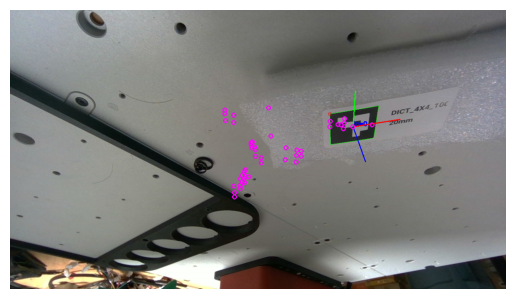

round:  47  /  47


In [14]:
robot_ip = "192.168.254.87"
joint_recorded = [
#{"cmd": "tool", "lz":47.95}
#{"cmd": "tool", "lz":77.35}

#{"cmd": "tool", "lz":77.35}

{"cmd": "jmove", "rel": 0, "j0": -42.6, "j1": 45.48, "j2": -128.69, "j3": -0.79, "j4": 3.49, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -41.22, "j1": 45.48, "j2": -128.69, "j3": -0.79, "j4": 4.06, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -41.62, "j1": 45.48, "j2": -128.69, "j3": -0.79, "j4": 4.06, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -42.58, "j1": 45.48, "j2": -128.69, "j3": -0.79, "j4": 4.86, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -40.91, "j1": 45.48, "j2": -128.69, "j3": -0.79, "j4": 2.55, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -40.89, "j1": 45.48, "j2": -128.69, "j3": -0.79, "j4": 4.88, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -40.91, "j1": 45.48, "j2": -128.69, "j3": -0.79, "j4": 3.54, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -56.91, "j1": 26.13, "j2": -111.01, "j3": -19.01, "j4": 8.44, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -56.93, "j1": 26.13, "j2": -111.01, "j3": -19.01, "j4": 6.9, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -57.63, "j1": 26.13, "j2": -111.01, "j3": -19.01, "j4": 6.13, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -57.63, "j1": 26.13, "j2": -111.01, "j3": -19.01, "j4": 8.44, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -57.66, "j1": 26.13, "j2": -111.01, "j3": -19.01, "j4": 6.9, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -25.14, "j1": 24.35, "j2": -121.66, "j3": 84.75, "j4": 33.79, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -25.11, "j1": 24.35, "j2": -121.66, "j3": 84.75, "j4": 36.5, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -25.11, "j1": 24.35, "j2": -121.66, "j3": 84.75, "j4": 35.46, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -22.59, "j1": 24.35, "j2": -121.66, "j3": 84.75, "j4": 36.5, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -23.33, "j1": 24.35, "j2": -121.66, "j3": 84.75, "j4": 33.79, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -23.33, "j1": 24.35, "j2": -121.66, "j3": 84.75, "j4": 36.5, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -23.31, "j1": 24.32, "j2": -121.66, "j3": 84.75, "j4": 35.46, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -16.39, "j1": 40.74, "j2": -130.56, "j3": 97.43, "j4": 31.4, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -16.39, "j1": 40.74, "j2": -130.56, "j3": 97.43, "j4": 33.71, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -16.39, "j1": 40.74, "j2": -130.56, "j3": 97.43, "j4": 33.02, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -14.92, "j1": 40.74, "j2": -130.56, "j3": 97.43, "j4": 31.4, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -14.9, "j1": 40.74, "j2": -130.56, "j3": 97.43, "j4": 33.02, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -15.82, "j1": 40.74, "j2": -130.56, "j3": 97.43, "j4": 31.4, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -15.82, "j1": 40.74, "j2": -130.56, "j3": 97.43, "j4": 33.02, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -61.72, "j1": 34.3, "j2": -103.34, "j3": -71.81, "j4": 20.41, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -61.7, "j1": 34.3, "j2": -103.34, "j3": -71.81, "j4": 21.64, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -59.66, "j1": 34.3, "j2": -103.34, "j3": -71.81, "j4": 20.41, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -59.66, "j1": 34.3, "j2": -103.34, "j3": -71.81, "j4": 21.62, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -61.13, "j1": 34.3, "j2": -103.34, "j3": -71.81, "j4": 20.41, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -61.88, "j1": 34.3, "j2": -103.34, "j3": -71.81, "j4": 20.7, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -61.9, "j1": 34.3, "j2": -103.34, "j3": -71.81, "j4": 21.27, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -60.89, "j1": 34.3, "j2": -103.34, "j3": -71.81, "j4": 20.7, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -60.89, "j1": 34.3, "j2": -103.34, "j3": -71.81, "j4": 22.3, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -61.88, "j1": 16.92, "j2": -114.04, "j3": -37.31, "j4": 50.36, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -61.88, "j1": 16.92, "j2": -114.04, "j3": -37.31, "j4": 53.17, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -60.27, "j1": 16.92, "j2": -114.04, "j3": -37.31, "j4": 50.36, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -60.27, "j1": 16.92, "j2": -114.04, "j3": -37.31, "j4": 53.2, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -60.27, "j1": 16.92, "j2": -114.04, "j3": -37.31, "j4": 51.59, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -60.73, "j1": 16.92, "j2": -114.04, "j3": -37.31, "j4": 50.36, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -60.73, "j1": 16.92, "j2": -114.04, "j3": -37.31, "j4": 53.17, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -60.73, "j1": 16.92, "j2": -114.04, "j3": -37.31, "j4": 51.59, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -45.86, "j1": 34.74, "j2": -92.26, "j3": -17.6, "j4": -59.92, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -48.6, "j1": 33.31, "j2": -82.02, "j3": -2.33, "j4": -72.49, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -41.31, "j1": 27.05, "j2": -83.03, "j3": -0.73, "j4": -74.42, "j5": -12.17},
{"cmd": "jmove", "rel": 0, "j0": -42.89, "j1": 27.05, "j2": -83.03, "j3": -0.73, "j4": -73.61, "j5": -12.17},
]
#joint_variance = [[-10, 0, 10], [0], [0], [0], [-10, 0, 10],[0]]
#joint_variance = [[-5, 0, 5], [0], [0,], [-5, 0, 5], [-5, 0, 5],[0]] # good result with scale
#joint_variance = [[-2, 0, 2], [0], [0,], [0], [-2, 0, 2],[0]] # good result with scale
joint_variance = [[0], [0], [0,], [0], [0],[0]] # test

joint_deviation = list(itertools.product(*joint_variance))
target_joint_list = []
for j in joint_recorded:
    target_joint_list += [(np.array([j["j0"], j["j1"], j["j2"], j["j3"], j["j4"], j["j5"]]) +  joint).tolist() for joint in joint_deviation]

"""
System parameters
"""
robot_model = "dorna_ta" # robot model

"""
aruco board parameters
"""
aruco_id = 0 # detected marker
aruco_length= 20 # length in mm
aruco_dic="DICT_4X4_100" # aruco type
aruco_refine="CORNER_REFINE_APRILTAG"
aruco_subpix=False


# collected data
collected_data = []

# camera
camera = Camera()

# Robot
robot = Dorna()

for _ in range(1):
    if not camera.connect():
        print("can not connect to camera")
        break
    else:
        print("camera connected")
    
    if not robot.connect(robot_ip):
        print("can not connect to robot")
        break
    else:
        print("robot connected")
    
    # detection
    prm = {'detection': {'cmd': 'aruco', 'dictionary': aruco_dic, 'marker_length': aruco_length, 'refine': aruco_refine, 'subpix': aruco_subpix}}
    detection = Detection(camera=camera, robot=None, **prm)

    # update collected data
    collected_data.append(dorna_ta_eye_in_hand_camera_kit(robot, detection, target_joint_list, aruco_id))  

# close the connections
camera.close()
robot.close()
detection.close()

In [7]:
robot_ip = "192.168.254.87"
joint_recorded = [
#{"cmd": "tool", "lz":47.95}
#{"cmd": "tool", "lz":77.35}

{"cmd":"jmove","rel":0,"j0":-50.493164,"j1":27.663574,"j2":-99.909668,"j3":-3.032227,"j4":-16.765137,"j5":-9.953613},
{"cmd":"jmove","rel":0,"j0":-27.531738,"j1":19.841309,"j2":-103.07373,"j3":69.433594,"j4":15.754395,"j5":-9.953613},
{"cmd":"jmove","rel":0,"j0":-19.204102,"j1":26.652832,"j2":-111.181641,"j3":84.550781,"j4":31.574707,"j5":-9.931641},
{"cmd":"jmove","rel":0,"j0":-59.238281,"j1":22.763672,"j2":-73.168945,"j3":-81.210938,"j4":20.654297,"j5":-9.931641},
{"cmd":"jmove","rel":0,"j0":-37.30957,"j1":15.446777,"j2":-52.426758,"j3":-35.48584,"j4":-105.227051,"j5":-9.931641},
]
#joint_variance = [[-10, 0, 10], [0], [0], [0], [-10, 0, 10],[0]]
#joint_variance = [[-5, 0, 5], [0], [0,], [-5, 0, 5], [-5, 0, 5],[0]] # good result with scale
joint_variance = [[-2, 0, 2], [0], [0,], [0], [-2, 0, 2],[0]] # good result with scale
#joint_variance = [[0], [0], [0,], [0], [0],[0]] # test

joint_deviation = list(itertools.product(*joint_variance))
target_joint_list = []
for j in joint_recorded:
    target_joint_list += [(np.array([j["j0"], j["j1"], j["j2"], j["j3"], j["j4"], j["j5"]]) +  joint).tolist() for joint in joint_deviation]

"""
System parameters
"""
robot_model = "dorna_ta" # robot model

"""
aruco board parameters
"""
aruco_id = 0 # detected marker
aruco_length= 20 # length in mm
aruco_dic="DICT_4X4_100" # aruco type
aruco_refine="CORNER_REFINE_APRILTAG"
aruco_subpix=False

In [35]:
# init
robot = Dorna()
calibration = True
scale = False
type = "calibration_fast"
use_aruco = True
deg = 10

# clean collected data
data = prepare_data(collected_data, robot, use_aruco=use_aruco, thr=1)
print("data size: ", sum([len(d) for d in data]))


result = minimizer(data, robot, type= type, scale=scale, calibration=calibration, d=deg)
print("Optimal parameters:", result[0])
print("Objective function value:", result[1])
T = result[0][:6]
ej = result[0][-5:]
"""

# transformation matrix
x, e = minimizer(data, robot, type= type, scale=scale, calibration=calibration)

T = euler_matrix(x[:6]).tolist()
ej = x[-5:].tolist()
# Output the results
print("Optimal parameters:", x)
print("Objective function value:", e)
"""

distance:  0.29103384236372193
distance:  0.09609259874670964
distance:  0.34902531036297996
distance:  0.4027935941033285
distance:  0.25234382411953143
distance:  0.3325635104951599
distance:  0.46161475675590735
distance:  0.16255998923218626
distance:  0.37725618411259193
distance:  0.16810281685962397
distance:  0.35266854833953737
distance:  0.33292656007027793
distance:  0.4345134110175566
distance:  0.1361028639190784
distance:  0.29151686287544415
distance:  0.37975833689304395
distance:  0.3374394116630157
distance:  0.2738825828720067
distance:  0.3066375564123357
distance:  0.16027701132544536
distance:  0.22133778989233865
distance:  0.15447986164883354
distance:  0.3509126277202069
distance:  0.2641401689835663
distance:  0.20101269863851864
distance:  0.3937297816771876
distance:  0.16952676022084495
distance:  0.2348635951633944
distance:  0.23717172334309253
distance:  0.3775537403541726
distance:  0.11133725921251465
distance:  0.16203279867221598
distance:  0.2059920

'\n\n# transformation matrix\nx, e = minimizer(data, robot, type= type, scale=scale, calibration=calibration)\n\nT = euler_matrix(x[:6]).tolist()\nej = x[-5:].tolist()\n# Output the results\nprint("Optimal parameters:", x)\nprint("Objective function value:", e)\n'

In [3]:
from calibration import Calibration
from dorna2 import Dorna

robot = Dorna()
c = Calibration(robot, )
c.collected_data = collected_data
x = c.calibrate()

In [25]:

if type ==  "likelihood":
    T = [[0, -result.x[3], 0, result.x[0]],
        [result.x[3], 0, 0, result.x[1]],
        [0, 0, result.x[3], result.x[2]],
        [0, 0, 0, 1]]

camera_mount= {"type": "dorna_ta_j4_1", "T": [48.724, 29.581, -5.149, 0.081, -0.081, 90.125], "ej": [0.5, 0.5, 0.073, -0.377, -0.322, 0, 0, 0]}

#camera_mount = None
robot = Dorna()
print("Robot connected: ", robot.connect(robot_ip))
camera = Camera()

print("camera connected: ", camera.connect())

prm = {"camera_mount": camera_mount, 'detection': {'cmd': 'aruco', 'dictionary': aruco_dic, 'marker_length': aruco_length, 'refine': aruco_refine, 'subpix': aruco_subpix}}
detection = Detection(camera=camera, robot=robot, **prm)

retval = detection.run()
if retval:
    print('{"cmd":"lmove","rel":0,"x":'+str(retval[0]["xyz"][0])+',"y":'+str(retval[0]["xyz"][1])+',"z":'+str(retval[0]["xyz"][2])+'}')
    if True:
        print('{"cmd":"jmove","rel":1,"j0":'+str(-camera_mount["ej"][0])+',"j1":'+str(-camera_mount["ej"][1])+',"j2":'+str(-camera_mount["ej"][2])+',"j3":'+str(-camera_mount["ej"][3])+',"j4":'+str(-camera_mount["ej"][4])+'}')

end_pose = [248, -146, 87]
tcp = [0, 0, 50 ,0, 0, 0]
for r in retval:
    z = robot.pick_n_place(r["tvec"], end_pose=end_pose, ej=r["ej"], tcp=tcp, above=10, speed=0.5, corner=500)


# close the connections
robot.close()
camera.close()
detection.close()


Robot connected:  True
camera connected:  True
{"cmd":"lmove","rel":0,"x":283.5286520041389,"y":-224.60174312737652,"z":41.74054504925289}
{"cmd":"jmove","rel":1,"j0":-0.5,"j1":-0.5,"j2":-0.073,"j3":0.377,"j4":0.322}


Exception in thread Thread-12:
Traceback (most recent call last):
  File "c:\Users\hossein\AppData\Local\Programs\Python\Python39\lib\threading.py", line 973, in _bootstrap_inner
Exception in thread Thread-7:
Traceback (most recent call last):
  File "c:\Users\hossein\AppData\Local\Programs\Python\Python39\lib\threading.py", line 973, in _bootstrap_inner
Exception in thread Thread-24:
Traceback (most recent call last):
  File "c:\Users\hossein\AppData\Local\Programs\Python\Python39\lib\threading.py", line 973, in _bootstrap_inner
Exception in thread Thread-15:
Traceback (most recent call last):
  File "c:\Users\hossein\AppData\Local\Programs\Python\Python39\lib\threading.py", line 973, in _bootstrap_inner
Exception in thread Thread-5:
Traceback (most recent call last):
  File "c:\Users\hossein\AppData\Local\Programs\Python\Python39\lib\threading.py", line 973, in _bootstrap_inner
Exception in thread Thread-21:
Traceback (most recent call last):
  File "c:\Users\hossein\AppData\Local\Pr

In [22]:
robot_ip = "192.168.254.87"
robot = Dorna()
print("Robot connected: ", robot.connect(robot_ip))
#print(res)
end_pose = [248, -146, 87]
tcp = [0, 0, 50 ,0, 0, 0]
for r in retval:
    z = robot.pick_n_place(r["xyz"], end_pose=end_pose, ej=r["ej"], tcp=tcp, above=10, speed=0.5, corner=500)


Robot connected:  True


In [7]:
import json
for c in z:
    print(json.dumps(c))

{"cmd": "jmove", "rel": 0, "j0": -34.53013319850254, "j1": 30.867593581698586, "j2": -94.71025793407956, "j3": 0.9327996709571686, "j4": -25.936049279080752, "j5": -13.036821024642336, "vel": 36.0, "accel": 400.0, "jerk": 800.0, "cont": 0}
{"cmd": "jmove", "rel": 0, "j0": -34.493339304011045, "j1": 18.290481454887388, "j2": -89.04056526668525, "j3": 1.1181826922893139, "j4": -19.028901191035576, "j5": -13.200893258810083}
{"cmd": "sleep", "time": 0.5}
{"cmd": "jmove", "rel": 0, "j0": -34.53013319850254, "j1": 30.867593581698586, "j2": -94.71025793407956, "j3": 0.9327996709571686, "j4": -25.936049279080752, "j5": -13.036821024642336, "vel": 20.0, "accel": 160.0, "jerk": 200.0, "cont": 1, "corner": 100}
{"cmd": "jmove", "rel": 0, "j0": -40.512222152612026, "j1": 32.8378258567518, "j2": -115.43058629829501, "j3": 2.6169816648575788, "j4": -7.218782463605353, "j5": -20.740963081658208}


In [322]:
import pickle
with open('data.pkl', 'wb') as file:
    pickle.dump(collected_data, file)


In [28]:
import pickle

# Load the pickle file
with open('data_bad.pkl', 'rb') as file:  # Use 'rb' to read the file
    collected_data = pickle.load(file)


In [6]:
robot.kinematic.xyzabc_to_mat(np.array([0, 0, 0, 0, 0, 0]))

matrix([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

In [9]:
collected_data

[[{'joint': [-42.60498,
    45.483398,
    -128.693848,
    -0.791016,
    3.493652,
    -12.172852],
   't_target_2_cam': [48.62649738788605,
    -19.195105880498886,
    164.19999301433563],
   'aruco_t_target_2_cam': [48.74903680691042,
    -18.950007542062625,
    164.09291809564627],
   'aruco_r_target_2_cam': [177.49405032191245,
    -19.80763538673658,
    -2.001508571412554],
   'cmd': {'cmd': 'jmove',
    'rel': 0,
    'j0': -42.6,
    'j1': 45.48,
    'j2': -128.69,
    'j3': -0.79,
    'j4': 3.49,
    'j5': -12.17},
   'gt': [48.74903680691042, -18.950007542062625, 164.09291809564627]},
  {'joint': [-41.220703,
    45.483398,
    -128.693848,
    -0.791016,
    4.064941,
    -12.172852],
   't_target_2_cam': [56.044433265924454,
    -16.394663602113724,
    164.09999132156372],
   'aruco_t_target_2_cam': [56.268202984088184,
    -16.38032174885767,
    164.52287224573692],
   'aruco_r_target_2_cam': [176.93552220820047,
    -17.538131762522465,
    -1.5384570233100168],
   '

In [12]:
import json
for x in collected_data[0]:
    print(json.dumps(x["cmd"]))

{"cmd": "jmove", "rel": 0, "j0": -42.6, "j1": 45.48, "j2": -128.69, "j3": -0.79, "j4": 3.49, "j5": -12.17}
{"cmd": "jmove", "rel": 0, "j0": -41.22, "j1": 45.48, "j2": -128.69, "j3": -0.79, "j4": 4.06, "j5": -12.17}
{"cmd": "jmove", "rel": 0, "j0": -41.62, "j1": 45.48, "j2": -128.69, "j3": -0.79, "j4": 4.06, "j5": -12.17}
{"cmd": "jmove", "rel": 0, "j0": -42.58, "j1": 45.48, "j2": -128.69, "j3": -0.79, "j4": 4.86, "j5": -12.17}
{"cmd": "jmove", "rel": 0, "j0": -40.91, "j1": 45.48, "j2": -128.69, "j3": -0.79, "j4": 2.55, "j5": -12.17}
{"cmd": "jmove", "rel": 0, "j0": -40.89, "j1": 45.48, "j2": -128.69, "j3": -0.79, "j4": 4.88, "j5": -12.17}
{"cmd": "jmove", "rel": 0, "j0": -40.91, "j1": 45.48, "j2": -128.69, "j3": -0.79, "j4": 3.54, "j5": -12.17}
{"cmd": "jmove", "rel": 0, "j0": -56.91, "j1": 26.13, "j2": -111.01, "j3": -19.01, "j4": 8.44, "j5": -12.17}
{"cmd": "jmove", "rel": 0, "j0": -56.93, "j1": 26.13, "j2": -111.01, "j3": -19.01, "j4": 6.9, "j5": -12.17}
{"cmd": "jmove", "rel": 0, "

In [43]:
import base64
import requests
import json
import asyncio

    
def last_version(url):
    rtn = {}
    try:
        req = requests.get(url)
        print(req)
        if req.status_code == requests.codes.ok:
            print("ali1")
            req = req.json()  # the response is a JSON
            print("ali2")
            content = base64.b64decode(req['content']).decode("utf-8")
            print("ali3")
            print(content)
            rtn = json.loads(content)
            print("ali4")
    except Exception as ex:
        print(ex)
        pass
    return rtn

def last_version_async():
    url = "https://api.github.com/repos/dorna-robotics/upgrade/contents/version.json"
    rtn = {"to": "update_check", "broadcast": True, "error": 0, "msg": {}}
    rtn["msg"] = last_version(url)
    print(rtn["msg"])
    return rtn

In [44]:
last_version_async()

<Response [200]>
ali1
ali2
ali3
{
	"dorna_lab": "2.1.0",
	"api": "2.1.3",
	"server_dorna_2": "110",
	"server_dorna_2s": "203",
	"server_dorna_ta": "304"
}
ali4
{'dorna_lab': '2.1.0', 'api': '2.1.3', 'server_dorna_2': '110', 'server_dorna_2s': '203', 'server_dorna_ta': '304'}


{'to': 'update_check',
 'broadcast': True,
 'error': 0,
 'msg': {'dorna_lab': '2.1.0',
  'api': '2.1.3',
  'server_dorna_2': '110',
  'server_dorna_2s': '203',
  'server_dorna_ta': '304'}}

In [ ]:
json